In [ ]:
pip install pyspark 

In [ ]:
pip install numpy 

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [17]:
import os
from pyspark.sql import SparkSession

# Create a Spark session
os.environ["HADOOP_HOME"] = "C:\\hadoop-3.3.5"

# Set hadoop.home.dir system property
os.environ["hadoop.home.dir"] = "C:\\hadoop-3.3.5"

# Initialize SparkSession
spark = SparkSession.builder.appName("ebay_analysis") \
        .config("spark.yarn.appMasterEnv.PYSPARK_PYTHON", "C:\spark-3.5.0\python") \
        .config("spark.executorEnv.PYSPARK_PYTHON", "C:\spark-3.5.0\python") \
        .getOrCreate()

# File location and type
file_location = "Data\\Processed_Cleaned_Dataset_Deduplicated.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# Read data from CSV file into a DataFrame
final_dataset = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

# Show the DataFrame
final_dataset.show()

+-----------+--------------------+--------------------+----------+------------+------+--------------------+-------+----------------+---------------------+------+--------------------+---------------+-----------------+
|        PID|            Category|            Location|  Latitude|   Longitude|Gender|               Title|  Price|Total Sold Items|Total Available Items|Rating|         Seller Name|Seller Feedback|Product Condition|
+-----------+--------------------+--------------------+----------+------------+------+--------------------+-------+----------------+---------------------+------+--------------------+---------------+-----------------+
|17179912701|Home and Industri...|Fort Payne, Alaba...|34.4442547| -85.7196893|Unisex|12 Pair Toddler G...|   8.49|              12|                   10|   4.0|             pam6209|          99.5%|    New with tags|
|25769815441|            Vehicles|New York, New Yor...|40.7127281| -74.0060152|Unisex|    1985 HARLEY FXRT|16500.0|              36|

In [18]:
final_dataset.printSchema()

root
 |-- PID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Total Sold Items: string (nullable = true)
 |-- Total Available Items: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Seller Name: string (nullable = true)
 |-- Seller Feedback: string (nullable = true)
 |-- Product Condition: string (nullable = true)


In [19]:
from pyspark.sql.functions import col

final_dataset = final_dataset.withColumn("PID", col("PID").cast("int"))
final_dataset = final_dataset.withColumn("Price", col("Price").cast("double"))
final_dataset = final_dataset.withColumn("Total Sold Items", col("Total Sold Items").cast("int"))
final_dataset = final_dataset.withColumn("Total Available Items", col("Total Available Items").cast("int"))
final_dataset = final_dataset.withColumn("Rating", col("Rating").cast("double"))

final_dataset.printSchema()

root
 |-- PID: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Total Sold Items: integer (nullable = true)
 |-- Total Available Items: integer (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Seller Name: string (nullable = true)
 |-- Seller Feedback: string (nullable = true)
 |-- Product Condition: string (nullable = true)


In [20]:
# Selecting the specific categories only... for the anlaysis 
from pyspark.sql.functions import col

allowed_categories = [
    "Antiques",
    "Men Accessories"
    "Home and Industrial Accessories",
    "Vehicles",
    "Kids",
    "Electronics",
    "Automotive",
    "Sports",
    "Women Clothing",
    "Musical Instruments",
    "Car Accessories",
    "Miscellaneous"
]

final_dataset = final_dataset.filter(col("Category").isin(allowed_categories))

final_dataset.show(truncate=False)


+-----+--------------+---------------------------------------+----------+------------+------+----------------------------------------------------------------------------+-------+----------------+---------------------+------+----------------------+---------------+-----------------+
|PID  |Category      |Location                               |Latitude  |Longitude   |Gender|Title                                                                       |Price  |Total Sold Items|Total Available Items|Rating|Seller Name           |Seller Feedback|Product Condition|
+-----+--------------+---------------------------------------+----------+------------+------+----------------------------------------------------------------------------+-------+----------------+---------------------+------+----------------------+---------------+-----------------+
|NULL |Vehicles      |New York, New York, United States      |40.7127281|-74.0060152 |Unisex|1985 HARLEY FXRT                                             

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import desc, col
sns.set(style="whitegrid")


In [26]:
# Classifying each location as East Coast vs West Coast into Region 
east_coast_states = ['New York', 'New Jersey', 'Florida', 'Georgia', 'Virginia']  # Add more as needed
west_coast_states = ['California', 'Oregon', 'Washington', 'Nevada', 'Arizona']  # Add more as needed


final_dataset = final_dataset.withColumn(
    "Region",
    when(
        final_dataset["Location"].rlike('|'.join(east_coast_states)),
        "East Coast"
    ).when(
        final_dataset["Location"].rlike('|'.join(west_coast_states)),
        "West Coast"
    ).otherwise("Other")
)


In [22]:
# Top selling products
top_selling_products = final_dataset.groupBy('Title').sum('Total Sold Items').orderBy('sum(Total Sold Items)', ascending=False)
top_selling_products.show()

+--------------------+---------------------+
|               Title|sum(Total Sold Items)|
+--------------------+---------------------+
|For Coolpad Legac...|                  999|
|Computer Desk PC ...|                  999|
|1 dozen 12  Psych...|                  999|
|550lb Commercial ...|                  998|
|Adapter Charger f...|                  998|
|For Apple Watch U...|                  998|
|OtterBox Defender...|                  998|
|For Samsung Galax...|                  997|
|For Samsung Galax...|                  997|
|Apple iPhone SE 2...|                  997|
|Boys Oxford Shoes...|                  997|
|Race Face Half Ne...|                  996|
|For iPhone 15 Pro...|                  995|
|For Samsung Galax...|                  995|
|Apple iPhone 13 P...|                  995|
|Original Otterbox...|                  994|
|Genuine Apple 60W...|                  994|
|Ocean Kayak Comfo...|                  993|
|96W Universal Lap...|                  992|
|Apple iPh

In [23]:
# Average price - category wise
avg_price_by_category = final_dataset.groupBy('Category').avg('Price').orderBy('avg(Price)', ascending=False)
avg_price_by_category.show()

+-------------------+------------------+
|           Category|        avg(Price)|
+-------------------+------------------+
|           Vehicles| 8926.422911572306|
|         Automotive|339.33832155109434|
|        Electronics| 316.9422751456342|
|      Miscellaneous|204.76002815004986|
|           Antiques| 189.7275154044922|
|             Sports|  58.1182735109716|
|Musical Instruments| 47.41074253891171|
|     Women Clothing| 34.75422095238133|
|               Kids|29.976834230581105|
|    Car Accessories|13.359402355678306|
+-------------------+------------------+


In [24]:
# Top Rated Sellers 
top_rated_sellers = final_dataset.groupBy('Seller Name').avg('Rating').orderBy('avg(Rating)', ascending=False)
top_rated_sellers.show()

+--------------------+-----------+
|         Seller Name|avg(Rating)|
+--------------------+-----------+
|bibigo battery store|        5.0|
|          Cards98765|        5.0|
|      randalync-half|        5.0|
|         technosgear|        5.0|
|    comfortable-shop|        5.0|
|           metacycle|        5.0|
|      vipproaudioinc|        5.0|
|  classic_car_seller|        5.0|
|           teshjor32|        5.0|
|          to95619366|        5.0|
|  Gardner Auto Parts|        5.0|
|            jess.le1|        5.0|
|            farmercl|        5.0|
|   LMT Arbitrage LLC|        5.0|
|        johnson2boys|        5.0|
|            usmai023|        5.0|
|              djitdo|        5.0|
|     THE-OUTDOOR-HUT|        5.0|
|            dilmcg_0|        5.0|
|    Fortune101_store|        5.0|
+--------------------+-----------+


In [27]:
# Sales by Region - East Coast vs West Coast vs Central(Other/Remaining States)
sales_by_region = final_dataset.groupBy('Region').sum('Total Sold Items').orderBy('sum(Total Sold Items)', ascending=False)
sales_by_region.show()

+----------+---------------------+
|    Region|sum(Total Sold Items)|
+----------+---------------------+
|     Other|              3183975|
|East Coast|              2120602|
|West Coast|              1848101|
+----------+---------------------+


In [30]:
# Sold Items - Product Condition Wise 
condition_impact_on_sales = final_dataset.groupBy('Product Condition').sum('Total Sold Items').orderBy('sum(Total Sold Items)', ascending=False)
condition_impact_on_sales.show()

+--------------------+---------------------+
|   Product Condition|sum(Total Sold Items)|
+--------------------+---------------------+
|                 New|              4230749|
|                Used|               922023|
|       New with tags|               716146|
|           Pre-owned|               414777|
|            Open box|               265054|
|    New without tags|               137526|
|New other (see de...|                84107|
|        New with box|                68404|
|For parts or not ...|                53657|
|  Good - Refurbished|                45888|
|Very Good - Refur...|                45061|
|Excellent - Refur...|                41228|
|Certified - Refur...|                29296|
|                  --|                19919|
|     New without box|                18941|
|    New with defects|                18245|
|           Brand New|                 8675|
|                Good|                 8413|
|           Very Good|                 5273|
|      New

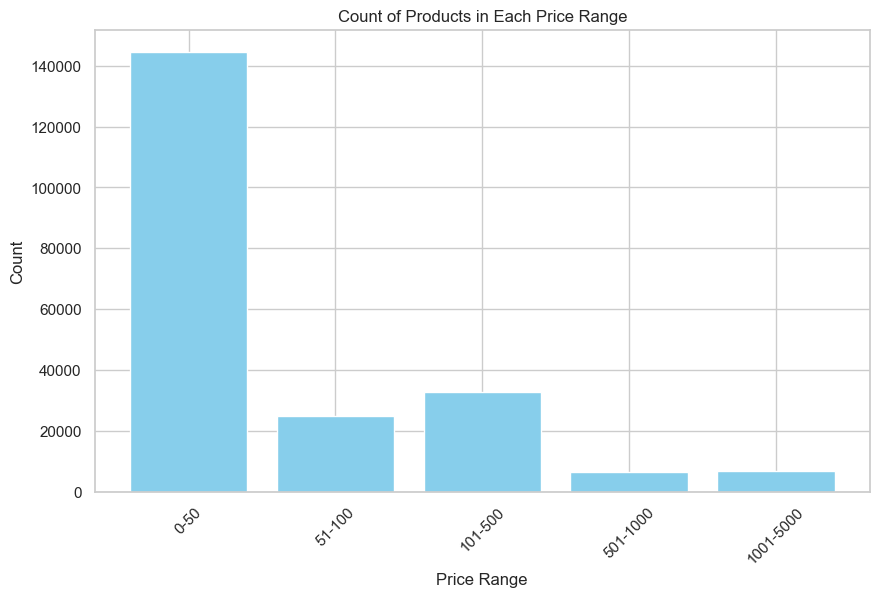

In [33]:
# Count of products in each price range
import pandas as pd 
import matplotlib.pyplot as plt 

price_ranges = [(0, 50), (51, 100), (101, 500), (501, 1000), (1001, 5000)]

price_range_counts = []
for lower, upper in price_ranges:
    count = final_dataset.filter((col('Price') >= lower) & (col('Price') <= upper)).count()
    price_range_counts.append((f"{lower}-{upper}", count))


price_range_df = pd.DataFrame(price_range_counts, columns=['Price Range', 'Count'])


plt.figure(figsize=(10, 6))
plt.bar(price_range_df['Price Range'], price_range_df['Count'], color='skyblue')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Count of Products in Each Price Range')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Sold Items to Available Items ratio.... 
inventory_balance = final_dataset.withColumn('Sold_to_Available_Ratio', col('Total Sold Items') / col('Total Available Items')).select('Title', 'Sold_to_Available_Ratio')
inventory_balance.show()

+--------------------+-----------------------+
|               Title|Sold_to_Available_Ratio|
+--------------------+-----------------------+
|    1985 HARLEY FXRT|     1.1612903225806452|
|6 Pair Boys or Gi...|                    1.8|
|Apple iPhone 5C 8...|      7.148148148148148|
|BI03XL ON03XL Bat...|     0.8529411764705882|
|Electronic YL 99K...|     0.3333333333333333|
|Franklin Sports F...|                    0.5|
|HOME is where lov...|     12.333333333333334|
|Inflatable Swimmi...|     2.6666666666666665|
|Kids Star Karaoke...|                   16.5|
|LA BLUES WOMENS J...|                   12.0|
|LG 65 NanoCell 99...|      1.303030303030303|
|Lavadora Mini Por...|     0.6666666666666666|
|MAGGIE T  Womens ...|                    1.0|
|MSI H270A PRO MOT...|   0.043478260869565216|
|Maytag Neptune Dr...|                   0.64|
|NEW  Samsung Gala...|     0.5588235294117647|
|NEW Premium Emerg...|      6.428571428571429|
|NIB Sunbeam 07 cu...|                   25.0|
|OTHER STORIE

C:\Users\dhrum\AppData\Local\Temp\ipykernel_8580\1433606009.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


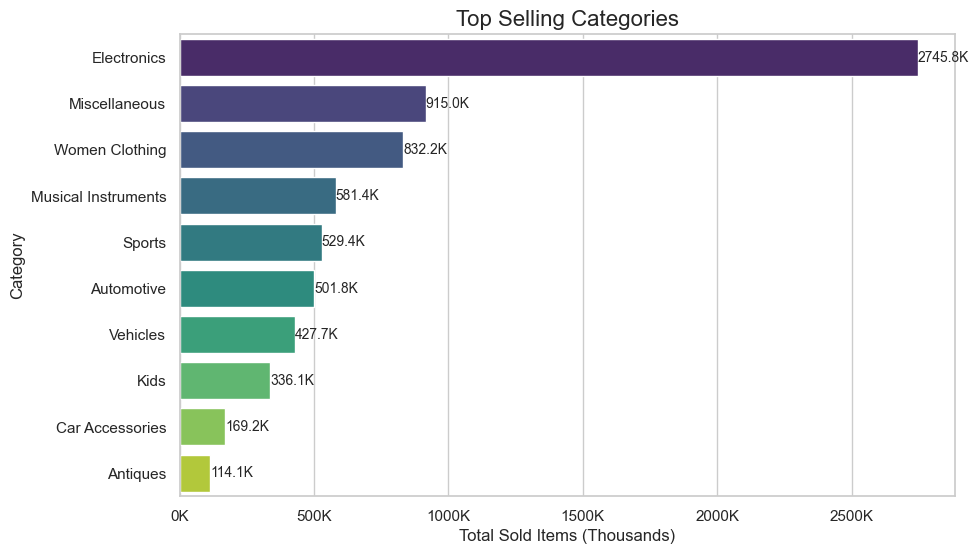

In [34]:
# Count of Products - Top Selling Categories - Bar Graph

from pyspark.sql.functions import desc, col, sum
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

top_selling_categories = (
    final_dataset
    .groupBy("Category")
    .agg(sum(col("Total Sold Items")).alias("Total Sold Items"))
    .orderBy(desc("Total Sold Items"))
)

top_selling_categories = top_selling_categories.withColumn(
    "Total Sold Items (Thousands)",
    col("Total Sold Items") / 1e3  # Dividing by 1 thousand to convert to thousands
)

colors = sns.color_palette("viridis", n_colors=len(top_selling_categories.collect()))

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    x="Total Sold Items (Thousands)",
    y="Category",
    data=top_selling_categories.toPandas(),
    palette=colors,
)

plt.title("Top Selling Categories", fontsize=16)
plt.xlabel("Total Sold Items (Thousands)", fontsize=12)
plt.ylabel("Category", fontsize=12)

bar_plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}K'))

for index, value in enumerate(top_selling_categories.collect()):
    bar_plot.text(value["Total Sold Items (Thousands)"], index, f'{value["Total Sold Items (Thousands)"]:.1f}K', ha="left", va="center", fontsize=10)

plt.show()


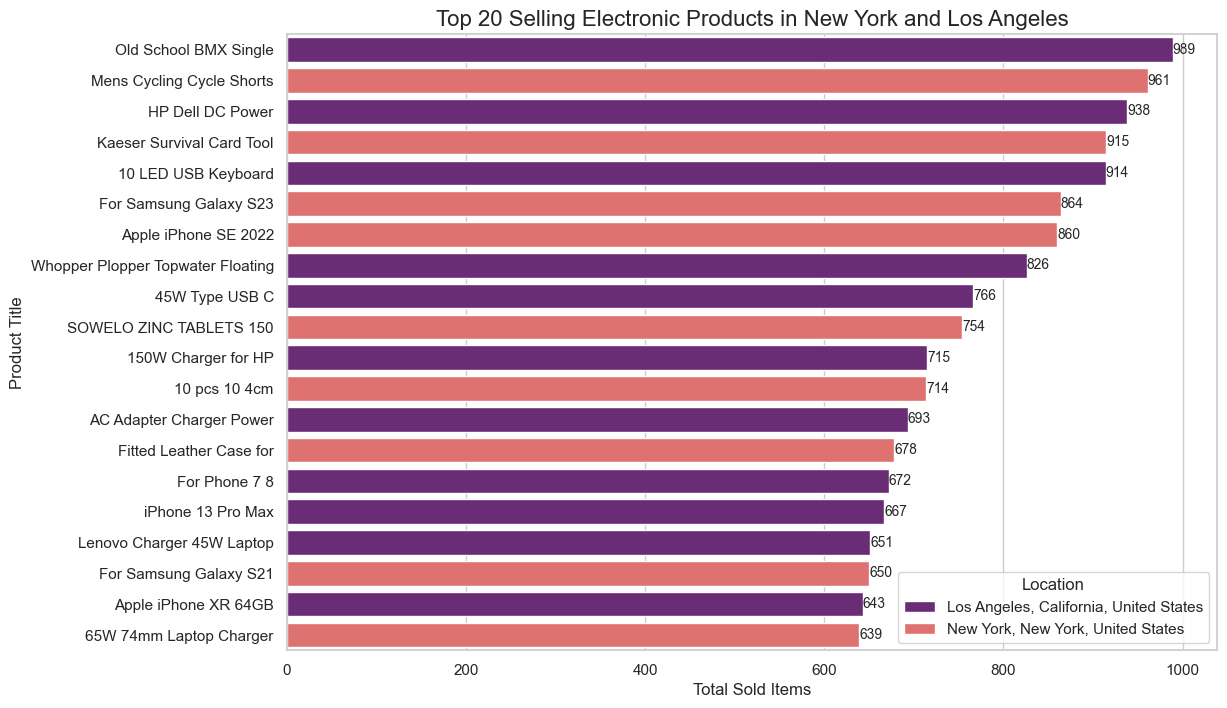

In [35]:
# Comparing Sales of Electronics in NY vs LA 

from pyspark.sql.functions import desc, col, sum
import seaborn as sns
import matplotlib.pyplot as plt

top_selling_electronic = (
    final_dataset
    .filter((col("Category") == "Electronics") &
            ((col("Location") == "New York, New York, United States") |
             (col("Location") == "Los Angeles, California, United States")))
    .groupBy("Location", "Title")
    .agg(sum(col("Total Sold Items")).alias("Total Sold Items"))
    .orderBy(desc("Total Sold Items"))
)

top_selling_electronic = top_selling_electronic.limit(20)

top_selling_electronic_df = top_selling_electronic.toPandas()

top_selling_electronic_df['Shortened Title'] = top_selling_electronic_df['Title'].apply(lambda x: ' '.join(x.split()[:4]))


plt.figure(figsize=(12, 8))
bar_plot_automotive = sns.barplot(
    x="Total Sold Items",
    y="Shortened Title",
    hue="Location",  # Distinguishing by location
    data=top_selling_electronic_df,
    palette="magma"
)

plt.title("Top 20 Selling Electronic Products in New York and Los Angeles", fontsize=16)
plt.xlabel("Total Sold Items", fontsize=12)
plt.ylabel("Product Title", fontsize=12)

for index, value in enumerate(top_selling_electronic_df['Total Sold Items']):
    bar_plot_automotive.text(value, index, f'{value:.0f}', ha="left", va="center", fontsize=10)

plt.show()



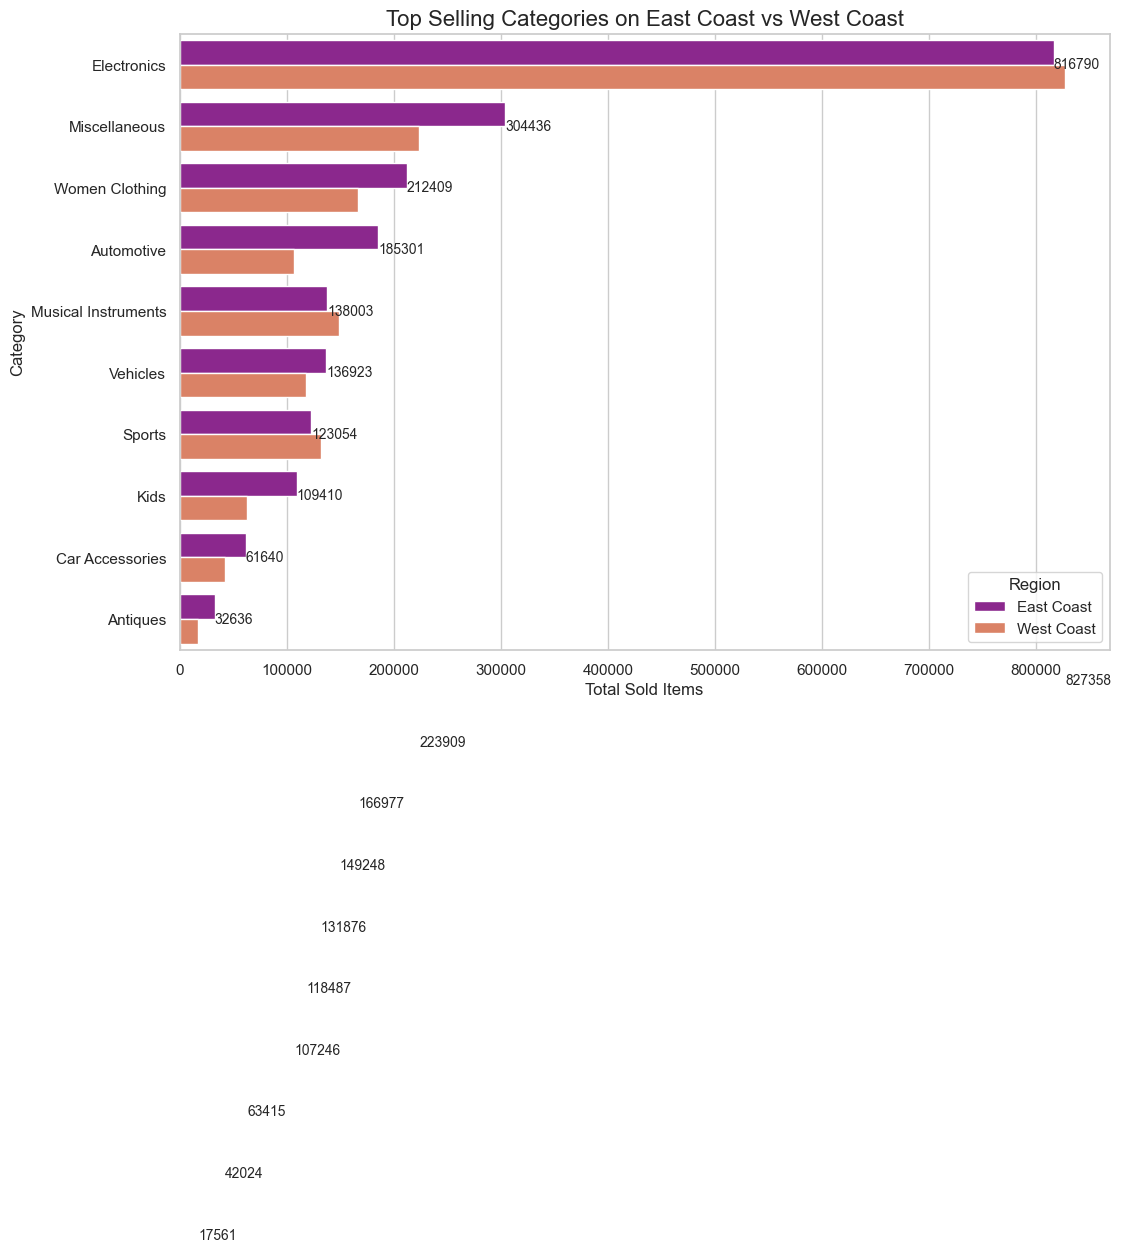

In [36]:
# Top Selling Categories in East Coast vs West Coast 

from pyspark.sql.functions import when, col, sum
import seaborn as sns
import matplotlib.pyplot as plt


filtered_dataset = final_dataset.filter(final_dataset["Region"] != "Other")


top_selling_categories = (
    filtered_dataset
    .groupBy("Region", "Category")
    .agg(sum(col("Total Sold Items")).alias("Total Sold Items"))
    .orderBy("Region", desc("Total Sold Items"))
)

top_selling_categories = top_selling_categories.limit(20)

top_selling_categories_df = top_selling_categories.toPandas()


plt.figure(figsize=(12, 8))
bar_plot_categories = sns.barplot(
    x="Total Sold Items",
    y="Category",
    hue="Region",
    data=top_selling_categories_df,
    palette="plasma"
)

plt.title("Top Selling Categories on East Coast vs West Coast", fontsize=16)
plt.xlabel("Total Sold Items", fontsize=12)
plt.ylabel("Category", fontsize=12)

for index, value in enumerate(top_selling_categories_df['Total Sold Items']):
    bar_plot_categories.text(value, index, f'{value:.0f}', ha="left", va="center", fontsize=10)

plt.show()


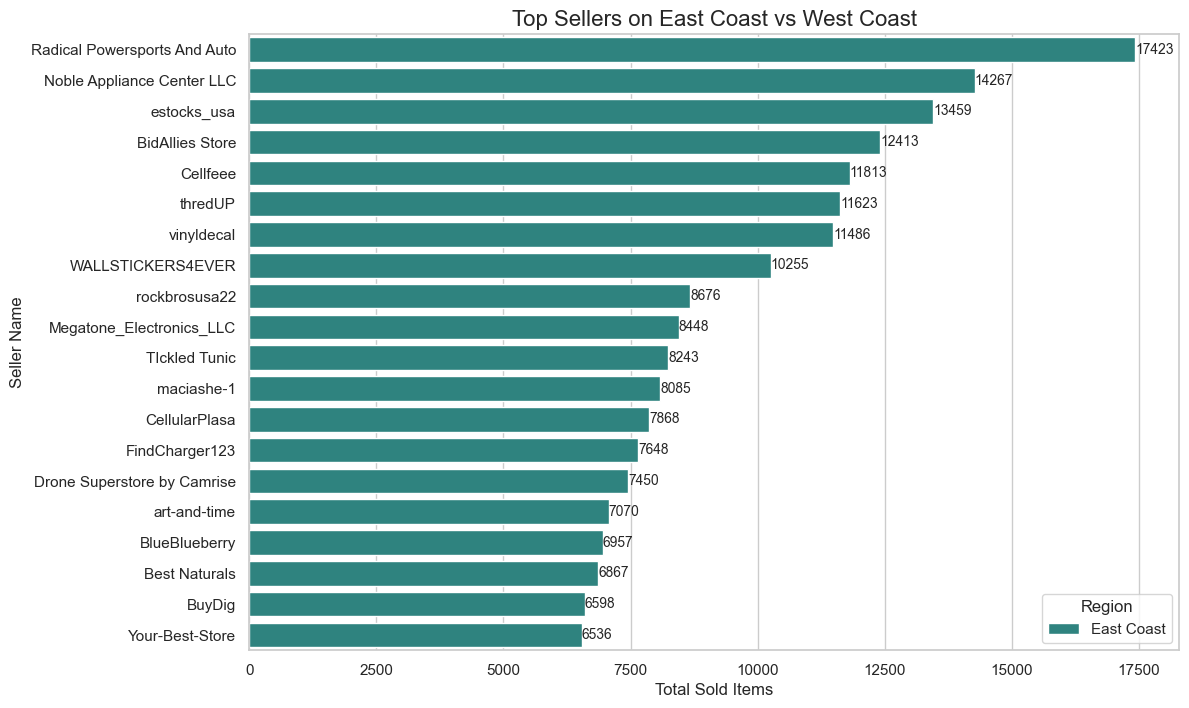

In [37]:
# Top Sellers on East Coast vs West Coast 

from pyspark.sql.functions import when, col, sum
import seaborn as sns
import matplotlib.pyplot as plt

east_coast_states = ['New York', 'New Jersey', 'Florida', 'Georgia', 'Virginia']  # Add more as needed
west_coast_states = ['California', 'Oregon', 'Washington', 'Nevada', 'Arizona', 'Chicago', 'Texas']  # Add more as needed


final_dataset = final_dataset.withColumn(
    "Region",
    when(
        final_dataset["Location"].rlike('|'.join(east_coast_states)),
        "East Coast"
    ).when(
        final_dataset["Location"].rlike('|'.join(west_coast_states)),
        "West Coast"
    ).otherwise("Other")
)

filtered_dataset = final_dataset.filter(final_dataset["Region"] != "Other")

top_sellers = (
    filtered_dataset
    .groupBy("Region", "Seller Name")
    .agg(sum(col("Total Sold Items")).alias("Total Sold Items"))
    .orderBy("Region", desc("Total Sold Items"))
)

top_sellers = top_sellers.limit(20)

top_sellers_df = top_sellers.toPandas()

plt.figure(figsize=(12, 8))
bar_plot_sellers = sns.barplot(
    x="Total Sold Items",
    y="Seller Name",
    hue="Region",
    data=top_sellers_df,
    palette="viridis"
)

plt.title("Top Sellers on East Coast vs West Coast", fontsize=16)
plt.xlabel("Total Sold Items", fontsize=12)
plt.ylabel("Seller Name", fontsize=12)

for index, value in enumerate(top_sellers_df['Total Sold Items']):
    bar_plot_sellers.text(value, index, f'{value:.0f}', ha="left", va="center", fontsize=10)

plt.show()


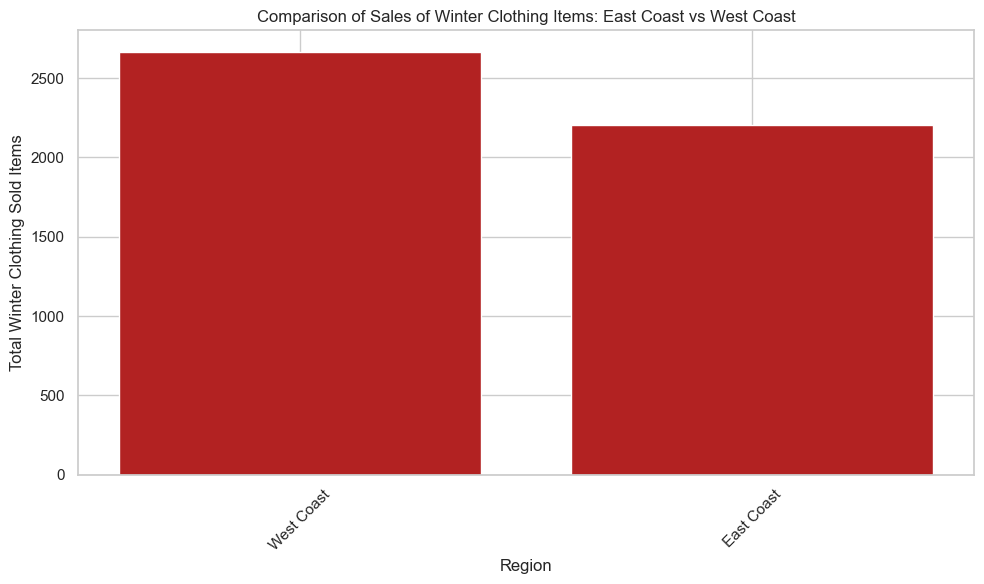

In [48]:
# Classifying specific products as winter clothing and comparing the sales in East Coast vs West Coast

from pyspark.sql.functions import col, lower, sum as pyspark_sum
import matplotlib.pyplot as plt

product_names = ["Jackets", "Hoodies", "Sweatshirt", "Winter Clothes"]
pattern = '|'.join([f"(?i){pn}" for pn in product_names])  # case insensitive regex pattern
filtered_df = filtered_dataset.filter(lower(col("Title")).rlike(pattern))

winter_sales_by_region = (
    filtered_df
    .groupBy("Region")
    .agg(pyspark_sum(col("Total Sold Items")).alias("Total Winter Clothing Sold Items"))
    .orderBy(desc("Total Winter Clothing Sold Items"))
)

winter_sales_by_region_pd = winter_sales_by_region.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(winter_sales_by_region_pd['Region'], winter_sales_by_region_pd['Total Winter Clothing Sold Items'], color='firebrick')
plt.title('Comparison of Sales of Winter Clothing Items: East Coast vs West Coast')
plt.xlabel('Region')
plt.ylabel('Total Winter Clothing Sold Items')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlapping
plt.show()

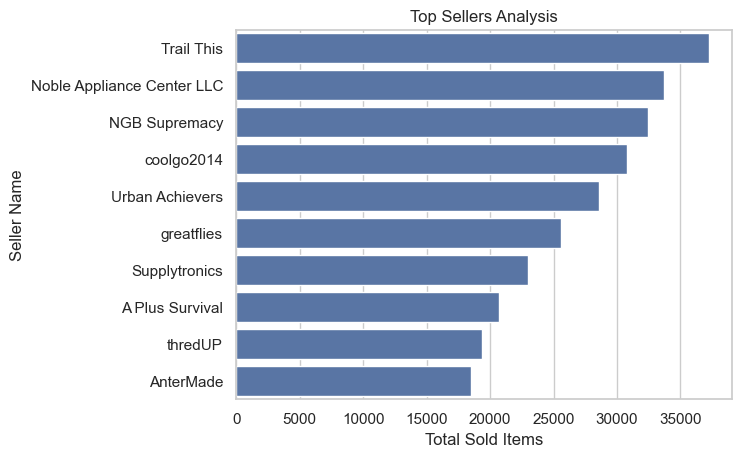

In [49]:
# Top Sellers and Sold Items count 

from pyspark.sql.functions import desc, col, avg, sum

seller_analysis = (
    final_dataset
    .groupBy("Seller Name")
    .agg(sum(col("Total Sold Items")).alias("Total Sold Items"),
         avg(col("Seller Feedback")).alias("Average Feedback"))
    .orderBy(desc("Total Sold Items"))
)

seller_analysis_df = seller_analysis.toPandas().head(10)
sns.barplot(x="Total Sold Items", y="Seller Name", data=seller_analysis_df)
plt.title("Top Sellers Analysis")
plt.xlabel("Total Sold Items")
plt.ylabel("Seller Name")
plt.show()


In [50]:
# Product count category wise 
from pyspark.sql.functions import desc

top_categories_df = (
    final_dataset
    .groupBy('Category')
    .count()
    .orderBy(desc('count'))
    .limit(10)
)

top_categories_df.show(truncate=False)

+-------------------+-----+
|Category           |count|
+-------------------+-----+
|Electronics        |63341|
|Women Clothing     |34125|
|Miscellaneous      |32682|
|Automotive         |19238|
|Vehicles           |17585|
|Kids               |14303|
|Musical Instruments|14006|
|Sports             |12760|
|Car Accessories    |6877 |
|Antiques           |5031 |
+-------------------+-----+


In [52]:
# Popular product in Each Category 
from pyspark.sql import Window
from pyspark.sql.functions import col, rank, sum as pyspark_sum

windowSpec = Window.partitionBy('Category').orderBy(col('Total Sold Items').desc())

ranked_products_df = (final_dataset
                      .withColumn('rank', rank().over(windowSpec)))

top_products_distinct_categories = (ranked_products_df
                                    .filter(col('rank') == 1)
                                    .select('Category', 'Title', 'Total Sold Items'))

top_products_distinct_categories.show(truncate=False)


+-------------------+-------------------------------------------------------------------------------+----------------+
|Category           |Title                                                                          |Total Sold Items|
+-------------------+-------------------------------------------------------------------------------+----------------+
|Antiques           |Suspender and Bow Tie Adults Men Olive Hunter Green Formal Wear Accessories    |674             |
|Automotive         |Omron Micro Limit Switch V1561C25 with 1 Roller Lever 15A 125250VAC E66F       |969             |
|Car Accessories    |2pc Black Plastic License Plate Frame Tag Cover for Car SUV Van Truck  D       |876             |
|Electronics        |For Coolpad Legacy  HARD HYBRID ARMOR PHONE CASE COVER BLACK HOLSTER BELT CLIP |999             |
|Kids               |Boys Oxford Shoes Brogue Formal Classic Footwear                               |997             |
|Miscellaneous      |Computer Desk PC Laptop Tab